# Uncertainty

In this notebook we present two different methods for adding uncertainty to a regression using neural networks. 

In the first one we use train a network to return a probability distribution for each point, i.e. to return both the regression and the error.

In the second one, we use a black-box regressor and train a neural network to predict the uncertainty.

In [55]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import pandas as pd
import math
from scipy import spatial
import tqdm

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

import os
import random

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [56]:
from matplotlib import pyplot as plt
%matplotlib inline

# Data

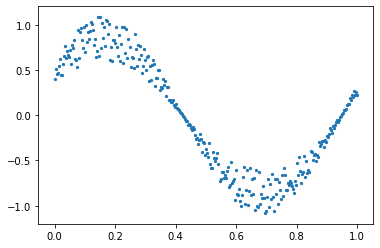

In [217]:
#generate noisy data

def f(x):
    #res = 25 * x + 3
    res = math.sin(6*x + 0.6)
    error = res * random.uniform(-0.4, 0.1)
    return res + error

values = []
x = np.linspace(0, 1, num=300)

# now using f we are going to create 300 values.
for i in x:
    y = f(i)
    values.append((i, y))
    
values = np.array(values)

# plot data
fig, ax = plt.subplots(figsize=(7,5))
ax.scatter(values[:, 0], values[:, 1], s=5)
#plt.savefig('uncertainty_data.png', dpi=300)
fig.show()

In [218]:
# Transform input and target data to tensor
X_train = torch.from_numpy(values[:, 0]).type(torch.FloatTensor)
y_train = torch.from_numpy(values[:, 1]).type(torch.FloatTensor)
X_train = X_train.view(-1, 1)
y_train = y_train.view(-1, 1)

## NormalLoss

In [846]:
class NormalLoss(object):
    
    def __call__(self, y_pred, y_true, **kwargs):
        mu = y_pred[:,0].view(-1, 1)
        sigma = y_pred[:,1].abs().view(-1, 1)
        return torch.mean(torch.log(sigma) + (torch.pow(y_true - mu, 2) / (2. * torch.pow(sigma, 2))))

## Regressor & Uncertainty Neural Network

In [847]:
# Define model's architecture
class UncertaintyRegressor(nn.Module):
    
    def __init__(self, hidden_shape):
        super().__init__()
        self.fc1 = nn.Linear(1, hidden_shape)
        self.fc2 = nn.Linear(hidden_shape, hidden_shape)
        self.fc3 = nn.Linear(hidden_shape, 2)
        
    def forward(self, x):
        l0 = torch.relu(self.fc1(x))
        l1 = torch.relu(self.fc2(l0))
        return self.fc3(l1)

In [884]:
# create network
model = UncertaintyRegressor(128)

# define loss, optimiser and learning rate
criterion = NormalLoss()
optimizer = optim.Adam(model.parameters(), lr=.0001)
losses = []

# set the number of steps and run the training process
epochs = 5000
for e in range(epochs):
    optimizer.zero_grad()
    output = model.forward(X_train)
    
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
# final loss
loss.item()

-2.0143330097198486

Text(0, 0.5, 'Loss')

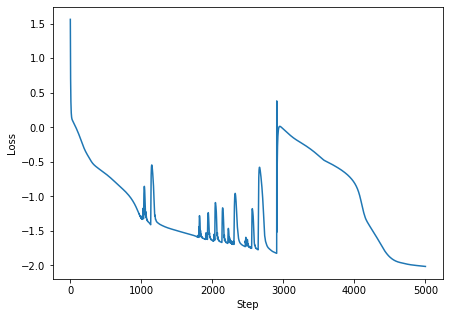

In [885]:
# plot loss evolution
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(losses)
ax.set_xlabel('Step')
ax.set_ylabel('Loss')
#plt.savefig('reg_unc_loss.png', dpi=300)

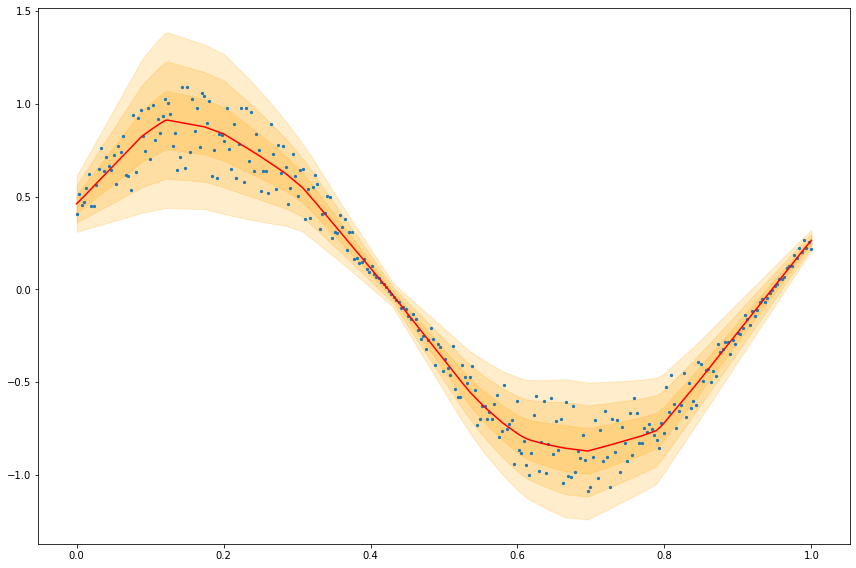

In [886]:
# obtain prediction
mu_sigma = output.detach().numpy()

# plot regression and uncertainty predictions
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

ax.fill_between(values[:,0], mu_sigma[:,0] - mu_sigma[:,1], mu_sigma[:,0] + mu_sigma[:,1], color='orange', alpha=.2)
ax.fill_between(values[:,0], mu_sigma[:,0] - mu_sigma[:,1] * 2, mu_sigma[:,0] + mu_sigma[:,1] * 2, color='orange', alpha=.2)
ax.fill_between(values[:,0], mu_sigma[:,0] - mu_sigma[:,1] * 3, mu_sigma[:,0] + mu_sigma[:,1] * 3, color='orange', alpha=.2)

ax.scatter(values[:,0], values[:,1], s=5)
ax.plot(values[:,0], mu_sigma[:,0], 'r')
#plt.savefig('reg_unc_pred.png', dpi=300)
plt.tight_layout()

## Black-box regressor and Uncertainty Neural Network

### Black-box regressor

In [715]:
#reg = DecisionTreeRegressor(max_depth=5)
#reg = GradientBoostingRegressor(random_state=0, n_estimators=25)
reg = SVR(kernel='rbf')
reg.fit(values[:, 0].reshape(-1, 1), values[:, 1].reshape(-1, 1))

/Users/gabriel.marin/anaconda3/envs/tfg/lib/python3.8/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

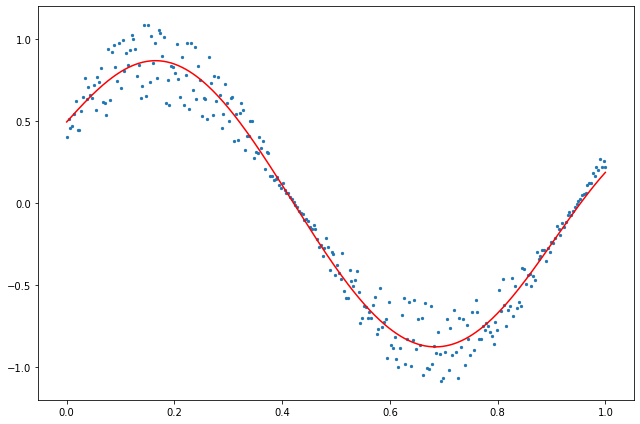

In [717]:
# get regression prediction
aux_y = reg.predict(values[:, 0].reshape(-1, 1))

# plot regression
fig, ax = plt.subplots(1, 1, figsize=(9, 6))
ax.scatter(values[:,0], values[:,1], s=5, label='training data')
ax.plot(values[:,0], aux_y, 'r', label='regression')
#plt.savefig('dt_5_pred.png', dpi=300)
plt.tight_layout()

### Uncertainty Neural Network

In [803]:
# define the architecture
class Uncertainty(nn.Module):
    
    def __init__(self, hidden_shape):
        super().__init__()
        self.fc1 = nn.Linear(1, hidden_shape)
        self.fc2 = nn.Linear(hidden_shape, hidden_shape)
        self.fc3 = nn.Linear(hidden_shape, 1)
        
    def forward(self, x):
        l0 = torch.relu(self.fc1(x))
        l1 = torch.relu(self.fc2(l0))
        return self.fc3(l1)

In [804]:
# we redefine the normalloss function
class NormalLoss(object):
    
    def __call__(self, mu, sigma, y_true, **kwargs):
        return torch.mean(torch.log(sigma) + (torch.pow(y_true - mu, 2) / (2. * torch.pow(sigma, 2))))
    


In [805]:
aux_reg = torch.from_numpy(aux_y).type(torch.FloatTensor)

# create network
model_un2 = Uncertainty(64)
criterion = NormalLoss()
optimizer = optim.Adam(model_un2.parameters(), lr=.0001)
criterion = NormalLoss()
losses_un2 = []
epochs = 6000

# run training process
for e in range(epochs):
    optimizer.zero_grad()
    output = model_un2.forward(X_train)
    
    mu = aux_reg.view(-1, 1).detach()
    sigma = output.abs().view(-1, 1)
    
    loss = criterion(mu, sigma, y_train)
    loss.backward()
    optimizer.step()
    losses_un2.append(loss.item())

Text(0, 0.5, 'Loss')

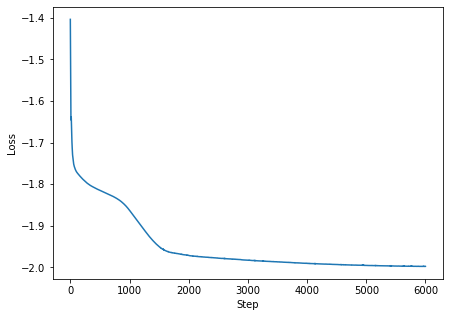

In [806]:
# plot loss
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(losses_un2)
ax.set_xlabel('Step')
ax.set_ylabel('Loss')
#plt.savefig('uncertainty_loss_decisiontree_5.png', dpi=300)

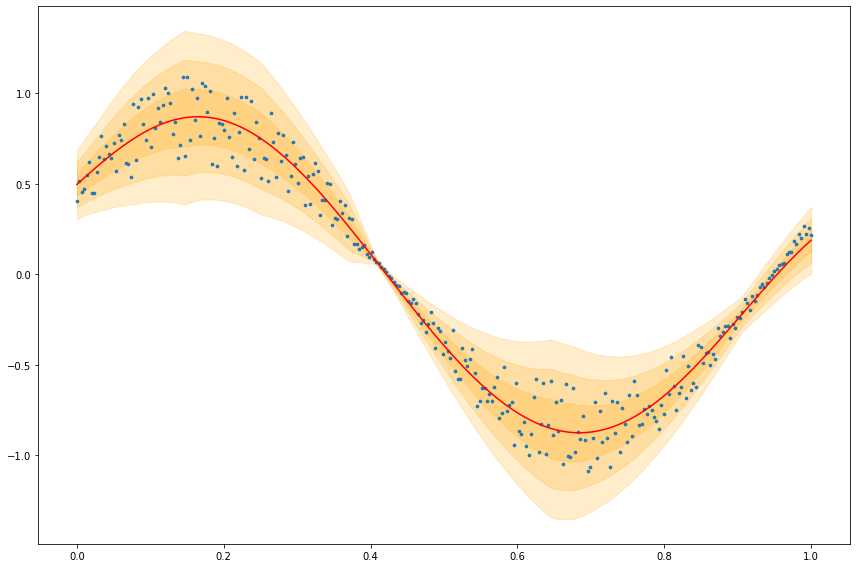

In [809]:
# obtain uncertainty and regression predictions
sigma = model_un2.forward(X_train).detach().numpy()
reg_pred = aux_reg.view(-1, 1).detach()

# plot result
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

ax.fill_between(values[:,0], reg_pred[:,0] - sigma[:,0], reg_pred[:,0] + sigma[:,0], color='orange', alpha=.2)
ax.fill_between(values[:,0], reg_pred[:,0] - sigma[:,0] * 2, reg_pred[:,0] + sigma[:,0] * 2, color='orange', alpha=.2)
ax.fill_between(values[:,0], reg_pred[:,0] - sigma[:,0] * 3, reg_pred[:,0] + sigma[:,0] * 3, color='orange', alpha=.2)
ax.scatter(values[:,0], values[:,1], s=7)
ax.plot(values[:,0], reg_pred[:,0], 'r')

plt.tight_layout()
#plt.savefig('uncertainty_svr_rbf.png', dpi=300)